Cluster count: 750
Cluster count: 700
Cluster count: 650
Cluster count: 600
Cluster count: 550
Cluster count: 500
Cluster count: 450
Cluster count: 400
Cluster count: 350
Cluster count: 300
Cluster count: 250
Cluster count: 200
Cluster count: 150
Cluster count: 100
Cluster count: 50
Cluster count: 3
NMI = 0.9447348755161592


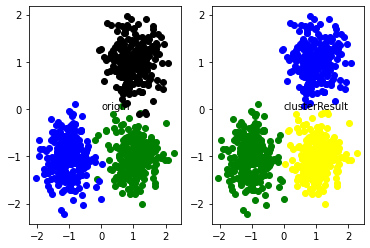

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance
from sklearn import metrics
from sklearn.datasets import make_blobs

# Returns the distance between two vectors
def dist(vecA, vecB):
    return np.sqrt(np.power(vecA - vecB, 2).sum())

# This class describes the data structure and method of operation for CURE clustering.
class CureCluster:
    def __init__(self, id__, center__):
        self.points = center__
        self.rep_points = center__
        self.center = center__
        self.index = [id__]
        
    def __repr__(self):
        return "Cluster " + " Size: " + str(len(self.points))
    
    # Computes and stores the centroid of this cluster, based on its points
    def compute_centroid(self, clust):
        total_points_1 = len(self.index)
        total_points_2 = len(clust.index)
        self.center = (self.center * total_points_1 + clust.center * total_points_2) / (total_points_1 + total_points_2)
        
    # Computes and stores representative points for this cluster
    def generate_rep_points(self, num_rep_points, alpha):
        temp_set = None
        for i in range(1, num_rep_points + 1):
            max_dist = 0
            max_point = None
            for p in range(0, len(self.index)):
                if i == 1:
                    min_dist = dist(self.points[p, :], self.center)
                else:
                    X = np.vstack([temp_set, self.points[p, :]])
                    tmp_dist = distance.pdist(X)
                    min_dist = tmp_dist.min()
                if min_dist >= max_dist:
                    max_dist = min_dist
                    max_point = self.points[p, :]
            if temp_set is None:
                temp_set = max_point
            else:
                temp_set = np.vstack((temp_set, max_point))
        for j in range(len(temp_set)):
            if self.rep_points is None:
                self.rep_points = temp_set[j, :] + alpha * (self.center - temp_set[j, :])
            else:
                self.rep_points = np.vstack((self.rep_points, temp_set[j, :] + alpha * (self.center - temp_set[j, :])))
                
    # Computes and stores distance between this cluster and the other one.
    def dist_rep(self, clust):
        dist_rep = float('inf')
        for repA in self.rep_points:
            if type(clust.rep_points[0]) != list:
                repB = clust.rep_points
                dist_temp = dist(repA, repB)
                if dist_temp < dist_rep:
                    dist_rep = dist_temp
            else:
                for repB in clust.rep_points:
                    dist_temp = dist(repA, repB)
                    if dist_temp < dist_rep:
                        dist_rep = dist_temp
        return dist_rep
    
    # Merges this cluster with the given cluster, recomputing the centroid and the representative points.
    def merge_with_cluster(self, clust, num_rep_points, alpha):
        self.compute_centroid(clust)
        self.points = np.vstack((self.points, clust.points))
        self.index = np.append(self.index, clust.index)
        self.rep_points = None
        self.generate_rep_points(num_rep_points, alpha)

# Describe the process of the CURE algorithm
def run_CURE(data, num_rep_points, alpha, num_des_cluster):
    # Initialization
    clusters = []
    num_cluster = len(data)
    num_Pts = len(data)
    dist_cluster = np.ones([len(data), len(data)])
    dist_cluster = dist_cluster * float('inf')
    for id_point in range(len(data)):
        new_clust = CureCluster(id_point, data[id_point, :])
        clusters.append(new_clust)
    for row in range(0, num_Pts):
        for col in range(0, row):
            dist_cluster[row][col] = dist(clusters[row].center, clusters[col].center)
    while num_cluster > num_des_cluster:
        if np.mod(num_cluster, 50) == 0:
            print('Cluster count:', num_cluster)
        # Find a pair of closet clusters
        min_index = np.where(dist_cluster == np.min(dist_cluster))
        min_index1 = min_index[0][0]
        min_index2 = min_index[1][0]
        # Merge
        clusters[min_index1].merge_with_cluster(clusters[min_index2], num_rep_points, alpha)
        # Update the distCluster matrix
        for i in range(0, min_index1):
            dist_cluster[min_index1, i] = clusters[min_index1].dist_rep(clusters[i])
        for i in range(min_index1 + 1, num_cluster):
            dist_cluster[i, min_index1] = clusters[min_index1].dist_rep(clusters[i])
        # Delete the merged cluster and its disCluster vector.
        dist_cluster = np.delete(dist_cluster, min_index2, axis=0)
        dist_cluster = np.delete(dist_cluster, min_index2, axis=1)
        del clusters[min_index2]
        num_cluster = num_cluster - 1
    print('Cluster count:', num_cluster)
    # Generate sample labels
    label = [0] * num_Pts
    for i in range(0, len(clusters)):
        for j in range(0, len(clusters[i].index)):
            label[clusters[i].index[j]] = i + 1
    return label

if __name__ == "__main__":
    centers = [[1, 1], [-1, -1], [1, -1]]
    data, Label_true = make_blobs(n_samples=750, centers=centers,
                                  cluster_std=0.4, random_state=0)
    num_rep_points = 5  # The number of representative points
    alpha = 0.1  # Shrink factor
    num_des_cluster = 3  # Desired cluster number
    Label_pre = run_CURE(data, num_rep_points, alpha, num_des_cluster)
    nmi = metrics.v_measure_score(Label_true, Label_pre)
    print("NMI =", nmi)
    scatterColors = ['black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown', 'cyan', 'brown',
                     'chocolate', 'darkgreen', 'darkblue', 'azure', 'bisque']
    plt.subplot(121)
    for i in range(data.shape[0]):
        color = scatterColors[Label_true[i]]
        plt.scatter(data[i, 0], data[i, 1], marker='o', c=color)
    plt.text(0, 0, "origin")
    
    plt.subplot(122)
    for i in range(data.shape[0]):
        color = scatterColors[Label_pre[i]]
        plt.scatter(data[i, 0], data[i, 1], marker='o', c=color)
    plt.text(0, 0, "clusterResult")
    plt.show()


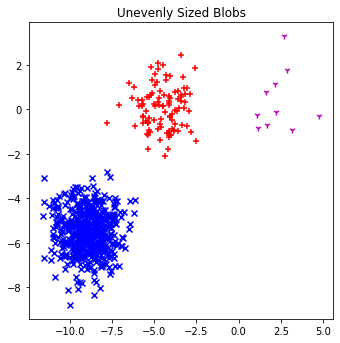

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs

plt.figure(figsize=(12,12))

#选取样本数量
n_samples = 1500
#选取随机因子
random_state = 170
#获取数据集
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

#聚类数量不正确时的效果
'''y_pred = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters=2).fit_predict(X)

plt.subplot(221)
plt.scatter(X[y_pred==0][:,0],X[y_pred==0][:,1], marker='x', color='b')
plt.scatter(X[y_pred==1][:,0],X[y_pred==1][:,1], marker='+', color='r')
plt.title("Incorrect Number of Blobs")
'''
#聚类数量正确时的效果
'''y_pred = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters=3).fit_predict(X)

plt.subplot(222)
plt.scatter(X[y_pred==0][:,0],X[y_pred==0][:,1], marker='x', color='b')
plt.scatter(X[y_pred==1][:,0],X[y_pred==1][:,1], marker='+', color='r')
plt.scatter(X[y_pred==2][:,0],X[y_pred==2][:,1], marker='1', color='m')
plt.title("Correct Number of Blobs")
'''
#类间方差存在差异的效果
'''x_varied,y_varied = make_blobs(n_samples=n_samples, cluster_std=[1.0,2.5,0.5], random_state=random_state)

y_pred = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters=3).fit_predict(x_varied)

plt.subplot(223)
plt.scatter(x_varied[y_pred==0][:,0],x_varied[y_pred==0][:,1], marker='x', color='b')
plt.scatter(x_varied[y_pred==1][:,0],x_varied[y_pred==1][:,1], marker='+', color='r')
plt.scatter(x_varied[y_pred==2][:,0],x_varied[y_pred==2][:,1], marker='1', color='m')
plt.title("Unequal Variance")
'''
#类的规模差异较大的效果
X_filtered = np.vstack((X[y==0][:500],X[y==1][:100],X[y==2][:10]))
y_pred=AgglomerativeClustering(affinity='euclidean',linkage='ward',n_clusters=3).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[y_pred==0][:,0],X_filtered[y_pred==0][:,1], marker='x', color='b')
plt.scatter(X_filtered[y_pred==1][:,0],X_filtered[y_pred==1][:,1], marker='+', color='r')
plt.scatter(X_filtered[y_pred==2][:,0],X_filtered[y_pred==2][:,1], marker='1', color='m')
plt.title("Unevenly Sized Blobs")

plt.show()
